###  This document is Specifically for Time per task/question analysis.

### Instruction on how to use this document is given right before each section. 

#### The 3 sections are:
#### 1) Execution.
#### 2) Exporting Processed File.
#### 3) Plot and Visualization.

### Import Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read Data

In [96]:
def read_data(file_path):
    '''Read Excel File'''
    
    df = pd.read_excel(file_path, engine = 'openpyxl')

    return df

### Prep data for time per question analysis

In [97]:
def prep_time_per_task(df):
    '''Extract time relevant data for each student per question and create new df'''
    
    task_time_df = (
    df.groupby(['candidate_id', 'question_number'], as_index=False)
      .first() 
      [['candidate_id', 'question_number', 'question_title', 'question_duration (sec)', 
        'incident_time_mins', 'auto_score_per_question', 'max_question_score']]
      .copy()
    )
		
    return task_time_df

### Convert time student spent on question from seconds to minutes

In [98]:
def convert_seconds_to_minutes(df):
    df['actual_time_per_questions_mins'] = round(df['question_duration (sec)']/60, 2)
    return df

### Calculate ideal time per question using proportional time allocation based on weighted scores

In [99]:
def calculate_ideal_time_per_task(df):
    df['expected_time_spent_mins'] = round(240 * df['max_question_score'] / 100, 2)
    return df

### Calculate statistics

In [100]:
def calculate_ideal_time_deviation(df):
    ''''Calculate anything over or under ideal time'''
    # Ideal time comparison
    df['deviation_ideal_time'] = df['actual_time_per_questions_mins'] - df['expected_time_spent_mins'].mean()

    return df


In [101]:
def get_stats_per_question(df):
    '''checks stasts such as mean median and std'''
    # Assuming 'question_id' identifies each question
    df = df.groupby('question_number').agg({
    'actual_time_per_questions_mins': ['mean', 'std', 'median'],
    'expected_time_spent_mins': 'first'  # expected time is same for all students per question
    })
    df.columns = ['mean_actual', 'std_actual', 'median_actual', 'expected']

    return df

### Plot over/under ideal time per question

In [103]:
def plot_over_under_ideal_time(df, tolerance = 2.5):
    
    # Aggregate: one bar per question_number
    plot_df = df.groupby('question_number', as_index=False)['deviation_ideal_time'].mean()

    # Over/under tolerance
    over = plot_df['deviation_ideal_time'] > tolerance
    under = plot_df['deviation_ideal_time'] < -tolerance

    # Distance from tolerance
    over_distance = (plot_df['deviation_ideal_time'] - tolerance).clip(lower=0)
    under_distance = (-tolerance - plot_df['deviation_ideal_time']).clip(lower=0)

    # Normalize color scales
    norm_over = plt.Normalize(0, over_distance.max() if over_distance.max() > 0 else 1)
    norm_under = plt.Normalize(0, under_distance.max() if under_distance.max() > 0 else 1)

    cmap_over = plt.get_cmap('Reds')
    cmap_under = plt.get_cmap('Blues')

    # Assign colors per bar
    colors = []
    for val in plot_df['deviation_ideal_time']:
        if val > tolerance:
            colors.append(cmap_over(norm_over(val - tolerance)))
        elif val < -tolerance:
            colors.append(cmap_under(norm_under(-tolerance - val)))
        else:
            colors.append((0.85, 0.85, 0.85, 1))  # light gray

    # Plot using plot_df — not original df!
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=plot_df,
        x='question_number',
        y='deviation_ideal_time',
        hue=plot_df.index,     # one color per bar
        palette=colors,
        dodge=False,
        legend=False,
        errorbar=None
    )

    # Decorations
    plt.xlabel('Question Number')
    plt.ylabel('Minutes Over/Under Ideal')
    plt.title('Time Over/Under Ideal per Question')

    plt.axhline(tolerance, color='darkgreen', linestyle='-.', linewidth=1, label=f'Max acceptable overtime (+{tolerance} min)')
    plt.axhspan(-tolerance, tolerance, color='green', alpha=0.15, label='Acceptable Over/Under Time Range')
    plt.axhline(-tolerance, color='darkgreen', linestyle='-.', linewidth=1, label=f'Min acceptable undertime (-{tolerance} min)')
    plt.axhline(0, color='black', linestyle='--', label='Ideal time basline (0 min deviation)')


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()

### Function to Run the Program

In [104]:
def run_analysis(file_path):

    # Read Data
    df = read_data(file_path)

    # prep and extract data from original df for time per task analysis
    task_time_df = prep_time_per_task(df)

    # convert time taken per task from second to minutes
    task_time_df = convert_seconds_to_minutes(task_time_df)

    # calculate ideal time 
    task_time_df = calculate_ideal_time_per_task(task_time_df)


    task_time_df = calculate_ideal_time_deviation(task_time_df)

    return task_time_df


### Export the Processed Analysis File

In [105]:
def export_data(df, output_path, file_format='xlsx'):
    """
    Save cleaned data to file 
    Args:
        df (pandas.DataFrame): Cleaned DataFrame
        output_path (str): Path to save the file
        file_format (str): Format to save ('xlsx', 'csv', 'json')
    """
    try:
        if file_format == 'xlsx':
            df.to_excel(output_path, index=False)
        elif file_format == 'csv':
            df.to_csv(output_path, index=False)
        elif file_format == 'json':
            df.to_json(output_path, orient='records', indent=2)
        else:
            raise ValueError(f"Unsupported format: {file_format}")
        
        print(f"Data saved successfully to {output_path}")
    except Exception as e:
        print(f"Error saving data: {e}")

In [106]:
# correlation = task_time_df[['actual_time_per_questions_mins', 'auto_score_per_question']].corr().iloc[0,1]
# print(f"Correlation between time spent and score (all rows): {correlation:.2f}")

### 1) Execute Analysis

In [107]:
task_time_df = run_analysis("data/cleaned_data_with_manual_scores2024.xlsx")

### 2) Export Processed File

In [108]:
export_data(task_time_df, 'processed data/Time_Per_Question_Analysis_2024.xlsx', 'xlsx')

Data saved successfully to processed data/Time_Per_Question_Analysis_2024.xlsx


### 3) Plot and Visualize Data

#### There is 1 visualization functions in here:

##### 1) plot_over_under_ideal_time(task_time_df)

#### How to use: to plot just pass the dataframe (task_time_df), wehich you get from the run_analysis method.

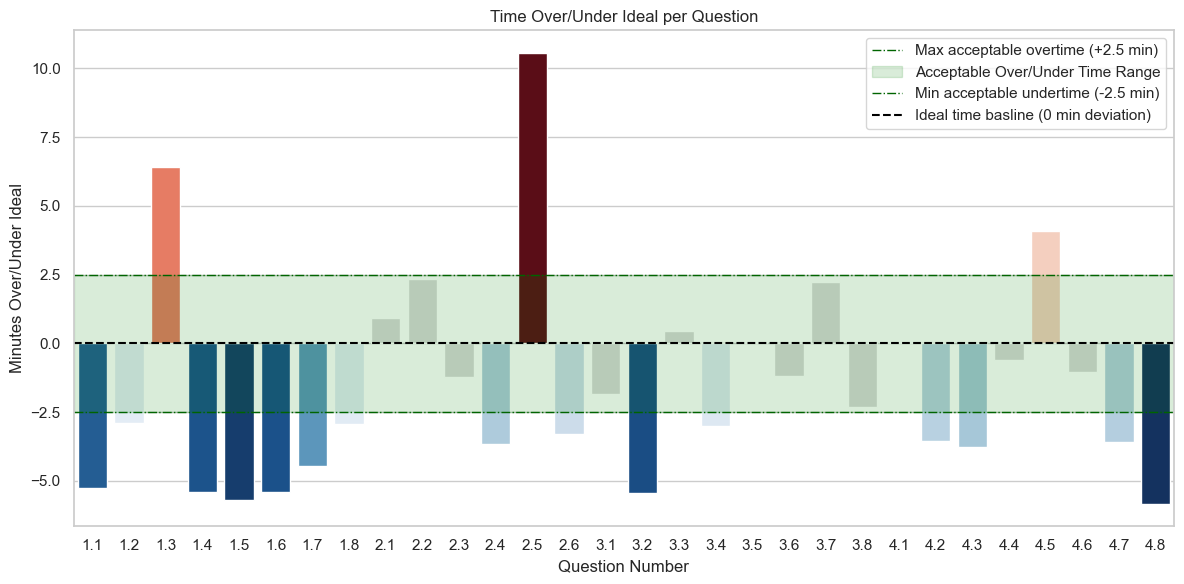

In [109]:
plot_over_under_ideal_time(task_time_df)

In [110]:
# Getting some statistic information on the time data
question_stats = get_stats_per_question(task_time_df)
question_stats

,mean_actual,std_actual,median_actual,expected
question_number,,,,
1.1,2.747206,2.213643,2.18,5.76
1.2,5.117329,3.684011,4.08,7.20
1.3,14.424569,9.591685,12.37,9.12
1.4,2.616151,1.599117,2.20,7.20
1.5,2.320650,1.740229,1.82,7.20
1.6,2.598717,1.669852,2.20,7.20
1.7,3.536397,2.387499,2.85,7.20
1.8,5.077715,3.860960,3.97,9.12
2.1,8.929227,7.016564,6.67,12.00
